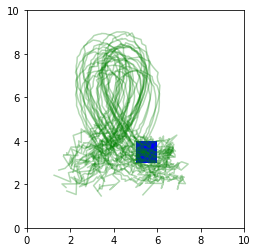

In [1]:
# %matplotlib
import intprim
from intprim.probabilistic_movement_primitives import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
import pandas as pd
from frechetdist import frdist
import math
from cem import CEM
from utils import *

dataset= np.load('/home/zhiyuan/notebook_script/0930/l_shape.npy')
# dataset=dataset[:,70:,]
fig, ax = plt.subplots()
ax.axis([0, 10, 0, 10])
plt.gca().set_aspect(1)
for i in range(30):
    ax.plot(dataset[i,:,0], dataset[i,:,1],'g-',alpha=0.3)
#add rectangle to plor
ax.add_patch(Rectangle((5, 3), 1, 1,
# ax.add_patch(Rectangle((4, 5), 3, 3,
             angle=0,
             edgecolor = 'none',
             facecolor = 'blue',
             fill=True,
             lw=1))
# for i in range(t_cond.shape[0]):
#     plt.plot(q_cond[i,0], q_cond[i,1],  marker="o", markersize=5)

plt.show() 

In [2]:

# dataset[:,:,0]=dataset[:,:,0]*2

# promp
num_joints =2
# Create a ProMP with Gaussian basis functions.

basis_model = intprim.basis.GaussianModel(8, 0.1, ["x","y"])
promp = ProMP(basis_model)
Q = dataset.transpose(0,2,1)

# Add Demonstrations to the ProMP, which in turn calculates the list of weights for each demonstration.
for i in range(len(Q)):
	promp.add_demonstration(Q[i])

n_samples = 30# Number of trajectoies to sample
domain = np.linspace(0,1,100)

# sample some trajs
samples_learn= []
for i in range(n_samples):
    samples, _ = promp.generate_probable_trajectory(domain)
    samples_learn.append(samples)
samples_learn=np.array(samples_learn)  


mean_margs = np.zeros(samples.shape)


upper_bound =  np.zeros([2,100])
lower_bound =  np.zeros([2,100])
sigma_s = np.zeros([2,2,100])
for i in range(len(domain)):
    mu_marg_q, Sigma_marg_q = promp.get_marginal(domain[i])
    sigma_s[:,:,i] = Sigma_marg_q
    std_q = np.diagonal(Sigma_marg_q) ** 0.5

    mean_margs[:,i] = mu_marg_q
    upper_bound[:,i] = mu_marg_q + std_q
    lower_bound[:,i] = mu_marg_q - std_q


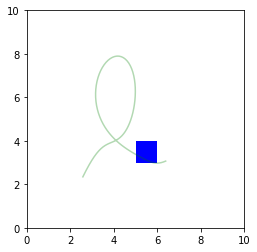

(30, 100, 2)


In [3]:
fig, ax = plt.subplots()
ax.axis([0, 10, 0, 10])
plt.gca().set_aspect(1)
ax.plot(mean_margs[0,:], mean_margs[1,:], 'g', alpha=0.3)

#add rectangle to plor
ax.add_patch(Rectangle((5, 3), 1, 1,
# ax.add_patch(Rectangle((4, 5), 3, 3,
             angle=0,
             edgecolor = 'none',
             facecolor = 'blue',
             fill=True,
             lw=1))


plt.show()
print(dataset.shape)

In [17]:
from pytorch_fid.fid_score import calculate_frechet_distance
mu_1= mean_margs.T.reshape(-1)
# mu_2= cond_traj.T.reshape(-1)
mu_2= np.ones(200)*8
sigma_1 = np.zeros([200,200])
sigma_2 = np.zeros([200,200])
for i in range(100):
    sigma_1[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_s[:,:,i]
#     sigma_2[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_con_array[:,:,i]
    sigma_2[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_s[:,:,i]*5
fid_cost1= calculate_frechet_distance(mu_1,sigma_1,mu_2,sigma_2) *0.01
fid_cost2= calculate_frechet_distance(mu_2,sigma_2,mu_1,sigma_1) *0.01
print(fid_cost1)
print(fid_cost2)

27.516317681990692
27.516317681990692


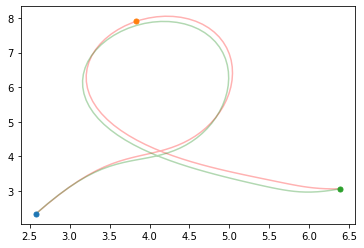

In [23]:
old_promp=promp

via_point= np.array([3.83612834, 7.9028387,0.5 ])

via_point = via_point.reshape([-1,3])
t_cond = np.zeros(2+via_point.shape[0])
t_cond[0]=0
t_cond[-1] = 1
for i in range(via_point.shape[0]):
    t_cond[i+1]=via_point[i,2]

q_cond =np.zeros([2+via_point.shape[0],2])
q_cond[0]= mean_margs[:,0]
q_cond[-1]= mean_margs[:,-1]
for i in range(via_point.shape[0]):
    q_cond[i+1]=via_point[i,:2]

# t_cond=np.array([0,20,99])
# # t_cond=np.array([0,20])
# q_cond =np.zeros([t_cond.shape[0],2])
# q_cond[0]= mean_margs[:,t_cond[0]]
# q_cond[1]= via_point
# q_cond[2]= mean_margs[:,t_cond[2]]

mu_w_cond_rec, Sigma_w_cond_rec=old_promp.get_basis_weight_parameters()

for i in range(t_cond.shape[0]):
    mu_w_cond_rec, Sigma_w_cond_rec = old_promp.get_conditioned_weights(t_cond[i], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)
cond_traj = np.zeros([2,100])
sigma_con_array =np.zeros([2,2,100]) 
upper_bound_con =  np.zeros([2,100])
lower_bound_con =  np.zeros([2,100])

for i in range(len(domain)):
    mu_marg_q_con, Sigma_marg_q_con = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
    sigma_con_array[:,:,i] = Sigma_marg_q_con
    cond_traj[:,i] = mu_marg_q_con
    std_q_con = np.diagonal(Sigma_marg_q_con)** 0.5
    upper_bound_con[:,i] = mu_marg_q_con + std_q_con
    lower_bound_con[:,i] = mu_marg_q_con - std_q_con
    


# %matplotlib
fig, ax = plt.subplots()
ax.plot(cond_traj[0,:], cond_traj[1,:], 'r', alpha=0.3)
ax.plot(mean_margs[0,:], mean_margs[1,:], 'g', alpha=0.3)
for i in range(t_cond.shape[0]):
    ax.plot(q_cond[i,0], q_cond[i,1],  marker="o", markersize=5)

plt.show()

In [27]:
mean_margs[:,50]

array([3.73612834, 7.7028387 ])

In [35]:

def get_reward(state, action):
    via_point= np.zeros(3)
    via_point[0]=action[0]
    via_point[1]=action[1]
    via_point[2]=action[2]
    # via_point= action
    old_promp=promp
    via_point = via_point.reshape([-1,3])
    t_cond = np.zeros(2+via_point.shape[0])
    t_cond[0]=0
    t_cond[-1] = 1 
    for i in range(via_point.shape[0]):
        t_cond[i+1]=via_point[i,2]

    q_cond =np.zeros([2+via_point.shape[0],2])
    q_cond[0]=mean_margs[:,0]
    q_cond[-1]=mean_margs[:,-1]
    # q_cond[0]= np.array([state[0],state[1]])
    # q_cond[-1]=np.array([state[2],state[3]])
    for i in range(via_point.shape[0]):
        q_cond[i+1]=via_point[i,:2]
    
    mu_w_cond_rec, Sigma_w_cond_rec=old_promp.get_basis_weight_parameters()

    for i in range(t_cond.shape[0]):
        mu_w_cond_rec, Sigma_w_cond_rec = old_promp.get_conditioned_weights(t_cond[i], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)

    cond_traj = np.zeros([2,100])
    sigma_con_array =np.zeros([2,2,100]) 
    for i in range(len(domain)):
        mu_marg_q_con, Sigma_marg_q_con = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
        sigma_con_array[:,:,i] = Sigma_marg_q_con
        cond_traj[:,i] = mu_marg_q_con

    limit = np.array([[state[0],state[0]+1],[state[1],state[1]+1]])   
    # limit = np.array([[state[4],state[4]+1],[state[5],state[5]+1]])   
    obs_dis= traj_rect_dist(cond_traj.T,  limit)  #new distance
    orig_obs= traj_rect_dist(mean_margs.T,  limit) #old distance
    obs_reward=obs_dis- orig_obs #new distance -old distance
    # mu_1= mean_margs.T.reshape(-1)
    mu_2= cond_traj.T.reshape(-1)
    # sigma_1 = np.zeros([200,200])
    sigma_2 = np.zeros([200,200])
    for i in range(100):
        # sigma_1[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_s[:,:,i]
        sigma_2[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_con_array[:,:,i]
    fid_cost= calculate_frechet_distance(mu_1,sigma_1,mu_2,sigma_2) *0.01

    alif =0.1

    reward =    obs_dis*(1-alif) -alif* fid_cost
    # reward =    obs_dis
    # reward = obs_reward
    # reward =   - fid_cost
    # reward =    obs_reward*(1-alif) -alif* fid_cost
    return reward


In [36]:
action= np.array([3.73612834, 7.7028387,0.5 ])
# action= mean_margs[]
state=[6,7]
get_reward(state, action)

0.9451350953019094

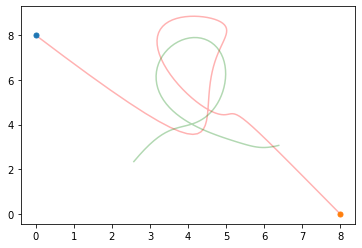

In [37]:
# 只改起点
old_promp=promp

    
t_cond = np.zeros(2)   
q_cond =np.zeros([2,2])    
t_cond[0]=0
t_cond[1]=1
# q_cond[0]= mean_margs[:,0]+20
# q_cond[1]= mean_margs[:,-1]+20
q_cond[0]=np.array([0,8])
q_cond[1]=np.array([8,0])

mu_w_cond_rec, Sigma_w_cond_rec=old_promp.get_basis_weight_parameters()

for i in range(t_cond.shape[0]):
    mu_w_cond_rec, Sigma_w_cond_rec = old_promp.get_conditioned_weights(t_cond[i], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)
cond_traj = np.zeros([2,100])
sigma_con_array =np.zeros([2,2,100]) 
upper_bound_con =  np.zeros([2,100])
lower_bound_con =  np.zeros([2,100])

for i in range(len(domain)):
    mu_marg_q_con, Sigma_marg_q_con = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
    sigma_con_array[:,:,i] = Sigma_marg_q_con
    cond_traj[:,i] = mu_marg_q_con
    std_q_con = np.diagonal(Sigma_marg_q_con)** 0.5
    upper_bound_con[:,i] = mu_marg_q_con + std_q_con
    lower_bound_con[:,i] = mu_marg_q_con - std_q_con
    

# %matplotlib
fig, ax = plt.subplots()
ax.plot(cond_traj[0,:], cond_traj[1,:], 'r', alpha=0.3)
ax.plot(mean_margs[0,:], mean_margs[1,:], 'g', alpha=0.3)
for i in range(t_cond.shape[0]):
    ax.plot(q_cond[i,0], q_cond[i,1],  marker="o", markersize=5)

plt.show()


In [22]:
def get_reward():
# def get_reward(via_point):
    old_promp=promp
#     via_point = via_point.reshape([-1,3])
#     t_cond = np.zeros(2+via_point.shape[0])
#     t_cond[0]=0
#     t_cond[-1] = 1
#     for i in range(via_point.shape[0]):
#         t_cond[i+1]=via_point[i,2]

#     q_cond =np.zeros([2+via_point.shape[0],2])
#     q_cond[0]= mean_margs[:,0]
#     q_cond[-1]= mean_margs[:,-1]
#     for i in range(via_point.shape[0]):
#         q_cond[i+1]=via_point[i,:2]
        
    
    t_cond = np.zeros(2)   
    q_cond =np.zeros([2,2])    
    t_cond[0]=0
    t_cond[1]=1
    # q_cond[0]= mean_margs[:,0]+20
    # q_cond[1]= mean_margs[:,-1]+20
    q_cond[0]=np.array([-5,-5])
    q_cond[1]=np.array([10,10])
        

    mu_w_cond_rec, Sigma_w_cond_rec=old_promp.get_basis_weight_parameters()

    for i in range(t_cond.shape[0]):
        mu_w_cond_rec, Sigma_w_cond_rec = old_promp.get_conditioned_weights(t_cond[i], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)

    cond_traj = np.zeros([2,100])
    sigma_con_array =np.zeros([2,2,100]) 
    for i in range(len(domain)):
        mu_marg_q_con, Sigma_marg_q_con = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
        sigma_con_array[:,:,i] = Sigma_marg_q_con
        cond_traj[:,i] = mu_marg_q_con
    mu_1= mean_margs.T.reshape(-1)
    mu_2= cond_traj.T.reshape(-1)
    sigma_1 = np.zeros([200,200])
    sigma_2 = np.zeros([200,200])
    for i in range(100):
        sigma_1[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_s[:,:,i]
        sigma_2[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_con_array[:,:,i]
    fid_cost= calculate_frechet_distance(mu_1,sigma_1,mu_2,sigma_2) *0.01


    reward =   fid_cost 

    return reward

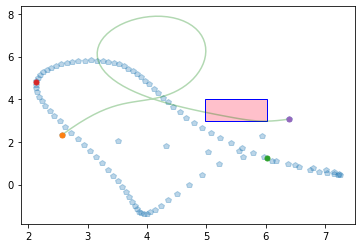

In [5]:
# %matplotlib
fig, ax = plt.subplots()
ax.plot(cond_traj[0,:], cond_traj[1,:], 'p', alpha=0.3)
ax.plot(mean_margs[0,:], mean_margs[1,:], 'g', alpha=0.3)
for i in range(t_cond.shape[0]):
    ax.plot(q_cond[i,0], q_cond[i,1],  marker="o", markersize=5)
#add rectangle to plor
# rectangle1=Rectangle((5, 3), 1, 1,
#              angle=0,
#              edgecolor = 'black',
#              facecolor = 'red',
#              fill=True,
#              lw=1)

# rectangle2=Rectangle((4.8, 2.8), 1.4, 1.4,
#              angle=0,
#              edgecolor = 'blue',
#              facecolor = 'pink',
#              fill=False,
#              lw=1)
rectangle3=Rectangle((4.98, 2.98), 1.04, 1.04,
             angle=0,
             edgecolor = 'blue',
             facecolor = 'pink',
             fill=True,
             lw=1)

# ax.add_patch(rectangle1)
# ax.add_patch(rectangle2)
ax.add_patch(rectangle3)
plt.show()


In [5]:
from pytorch_fid.fid_score import calculate_frechet_distance

mu_0= mean_margs.T.reshape(-1)
mu_1= cond_traj.T.reshape(-1)

sigma_0 = np.zeros([200,200])
sigma_1 = np.zeros([200,200])
for i in range(100):
    sigma_0[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_s[:,:,i]
    
for i in range(100):
    sigma_1[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_con_array[:,:,i]   

In [6]:
import time 
t1= time.time()
calculate_frechet_distance(mu_0,sigma_0,mu_1,sigma_1)

t2= time.time()
print("耗时",t2-t1) 

耗时 0.021087646484375


In [8]:
samples_cond= []
for i in range(n_samples):
    samples, _ = promp.generate_probable_trajectory(domain, mu_w_cond_rec, Sigma_w_cond_rec)
    samples_cond.append(samples)

plt.plot(cond_traj[0,:], cond_traj[1,:],'b-')
samples_cond=np.array(samples_cond)  
for i in range(samples_cond.shape[0]): 
    plt.plot(samples_cond[i,0,:], samples_cond[i,1,:], 'g--', alpha=0.3)
    
# plt.gca().add_patch(plt.Rectangle((4,5),3,3))
plt.gca().add_patch(plt.Rectangle((5,3),1,1))
plt.gca().axis("equal")  #ax.axis("equal") 
plt.show()

/home/zhiyuan/.local/lib/python3.8/site-packages/intprim-2.0-py3.8.egg/intprim/probabilistic_movement_primitives.py:291: RuntimeWarning: covariance is not positive-semidefinite.


In [30]:
# blended promp

def relu(x):
    return np.maximum(0, x)

def blend_promp(sigma_1,sigma_2,mu_1,mu_2,alphat_1,alphat_2):
      
    _sum_sig = np.linalg.inv(sigma_1/ alphat_1) +np.linalg.inv(sigma_2/ alphat_2)
    sigma_q_re=np.linalg.inv(_sum_sig)
    _sum_mu=np.linalg.inv(sigma_1/ alphat_1).dot(mu_1)+np.linalg.inv(sigma_2/ alphat_2).dot(mu_2)
    mu_q_re=sigma_q_re.dot(_sum_mu)
  
    return sigma_q_re, mu_q_re


re_mu_marg =np.zeros([2,100])
re_sigma_marg =np.zeros([2,2,100])
re_mu_marg[:,0]= mean_margs[:,0]
re_mu_marg[:,-1]=cond_traj[:,-1]
re_sigma_marg[:,:,0]= sigma_s[:,:,0]
re_sigma_marg[:,:,-1]= sigma_con_array[:,:,-1]

In [31]:
alpha_1=np.zeros(100)
alpha_2=np.zeros(100)
for i in np.arange(100):
    alpha_1[i] = domain[i]
    alpha_2[i] = 1 -alpha_1[i]
# alpha_1[:80]=0.999
# alpha_2[:80]=0.001
# alpha_1[80:]=0.001
# alpha_2[80:]=0.999

In [32]:
for i in np.arange(1,99):
    re_sigma_marg[:,:,i],re_mu_marg[:,i]= blend_promp(sigma_s[:,:,i],sigma_con_array[:,:,i],
                                                      mean_margs[:,i],cond_traj[:,i],alpha_1[i],alpha_2[i])

In [33]:
fig, ax = plt.subplots()
ax.plot(cond_traj[0,:], cond_traj[1,:], 'r', alpha=0.3)
ax.plot(mean_margs[0,:], mean_margs[1,:], 'g', alpha=0.3)
ax.plot(re_mu_marg[0,:], re_mu_marg[1,:], 'b', alpha=0.3)

for i in range(t_cond.shape[0]):
    ax.plot(q_cond[i,0], q_cond[i,1],  marker="o", markersize=5)
#add rectangle to plor
ax.add_patch(Rectangle((5, 3), 1, 1,
             angle=0,
             edgecolor = 'none',
             facecolor = 'blue',
             fill=True,
             lw=1))


plt.show()